# Tesla Stock Signal Prediction 

Using historical stock data to predict a "buy or sell" signal for a trading day. This notebook includes the following sections: 
- ##### Step 1: Feature Engineering 
- ##### Step 2: Data Preparation 
- ##### Step 3: Building RNN Model to predict stock signals
- ##### Step 4: Performing Hyperparameter Tuning 

Modelling and evaluation was performed without Social Media Sentiments from Twitter, this notebook will be utilized to discuss the differences of results when social media sentiment is not included in model training

In [1]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 6.5MB/s 


In [2]:
# Loading required libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, SimpleRNNCell, RNN, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot  as plt
import kerastuner as kt

pd.set_option("display.max_colwidth" , 100, "display.max_columns", 15)
np.random.seed(54)
tf.random.set_seed(54)


In [3]:
# Loading Raw Tesla Stock data containing daily metrics
tsla_df = pd.read_csv("https://raw.githubusercontent.com/DDave94/Stock-Prediction-DL/main/datasets/raw/Tesla/TSLA.csv")

# Loading Twitter Sentiment data containing daily twitter sentiment scores based on daily aggregate tweet analysis
twitter_df = pd.read_csv("https://raw.githubusercontent.com/DDave94/Stock-Prediction-DL/main/datasets/tsla-tweet-sentiments-lstm.csv")

### Feature Engineering
- Generating other prediction metrics such as:
    -  **Moving Average** : A moving average indicates the trend of the closing price movement and reduces the amount of "noise" on the price chart. We calculate different types of moving averages below. 
    - **Momentum** : The rate of acceleration at which the stock price is changing based on historical closing prices

- Adding Twitter sentiment feature column, the social media sentiment scores for each day of trading. However this feature will NOT be used for model training and evaluation. 
    - This data was only merged to create the same frame of reference for instaces as the other model which included twitter sentiments in analysis. This allows us to compare and contrast the existence of social media sentiment more effectively

- Generating target column "signal" using special moving averages 

In [4]:
# Calculation of historical moving averages of closing price (10 and 30 days of trading)
def MA(df, period):
    MA = pd.Series(df['Close'].rolling(period, min_periods=period).mean(), name='MA_' + str(period))
    return MA

tsla_df['MA10'] = MA(tsla_df, 10)
tsla_df['MA30'] = MA(tsla_df, 30)

#calculation of exponential moving average of closing price (10 and 30 days of trading)
def EMA(df, period):
    EMA = pd.Series(df['Close'].ewm(span=period, min_periods=period).mean(), name='EMA_' + str(period))
    return EMA

tsla_df['EMA10'] = EMA(tsla_df, 10)
tsla_df['EMA30'] = EMA(tsla_df, 30)


#Calculation of closing price momentum (10 and 30 days of trading)
def MOM(df, period):   
    MOM = pd.Series(df.diff(period), name='Momentum_' + str(period))   
    return MOM

tsla_df['MOM10'] = MOM(tsla_df['Close'], 10)
tsla_df['MOM30'] = MOM(tsla_df['Close'], 30)


In [5]:
# Merging the twitter sentiment scores for each day of stock trading
# This step is only performed when utilizing sentiment for stock signal prediction

tsla_df['Date'] = tsla_df['Date'].astype(str)
twitter_df['Date'] = twitter_df['Date'].astype(str)

merged_data = pd.merge(tsla_df,twitter_df, how='inner', on='Date')

#Dropping social media sentiment data
merged_data = merged_data.drop(columns=['TwitterSentiment'])

merged_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MA10,MA30,EMA10,EMA30,MOM10,MOM30
0,2017-01-03,42.972000,44.066002,42.192001,43.397999,43.397999,29616500,42.512800,39.694600,42.387158,40.585125,2.899998,5.666001
1,2017-01-04,42.950001,45.599998,42.862000,45.397999,45.397999,56067500,42.998000,39.974400,42.934584,40.895634,4.851998,8.393997
2,2017-01-05,45.284000,45.495998,44.389999,45.349998,45.349998,29558500,43.357199,40.255933,43.373750,41.183013,3.591999,8.445999
3,2017-01-06,45.386002,46.062000,45.090000,45.801998,45.801998,27639500,43.783399,40.508200,43.815250,41.481012,4.261997,7.567997
4,2017-01-09,45.793999,46.383999,45.599998,46.256001,46.256001,19897500,44.239999,40.762467,44.259023,41.789077,4.566002,7.628003


In [6]:
# Creating two columns SMA and LMA to label our dataset
# SMA (Short Moving Average)- The average of the closing price from the next five days in the future
# LMA (Long Moving Average)- The average of the closing price from the last ten days and the next five days in the future

full_data = merged_data
full_data['SMA'] = ""
full_data['LMA'] = ""

for ind in range(0, (full_data.shape[0]-5)):
    sma_frame = full_data['Close'].iloc[ind+1:ind+6]
    full_data['SMA'].iloc[ind] = sma_frame.mean()
  
    lma_frame_one = full_data['Close'].iloc[ind-10:ind]
    lma_frame_two = full_data['Close'].iloc[ind+1:ind+6]

    if (lma_frame_one.sum() == 0):
        full_data['LMA'].iloc[ind] = np.NaN
    else: 
        full_data['LMA'].iloc[ind] = (lma_frame_one.sum() + lma_frame_two.sum())/15

full_data['SMA'] = full_data['SMA'].replace('', np.NaN)
full_data['LMA'] = full_data['LMA'].replace('', np.NaN)

#Dropping any empty fields of data
full_data = full_data.dropna(axis=0)
print(full_data.head())

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


          Date       Open       High        Low      Close  Adj Close  \
10  2017-01-18  47.330002  47.942001  47.116001  47.672001  47.672001   
11  2017-01-19  49.450001  49.736000  48.150002  48.751999  48.751999   
12  2017-01-20  49.091999  49.200001  48.602001  48.945999  48.945999   
13  2017-01-23  49.169998  50.178001  49.099998  49.784000  49.784000   
14  2017-01-24  50.000000  50.959999  49.930000  50.922001  50.922001   

      Volume       MA10       MA30      EMA10      EMA30     MOM10      MOM30  \
10  18845000  46.298199  42.534400  46.122106  43.432292  4.274002  11.378002   
11  38661500  46.633599  42.914133  46.600269  43.775499  3.354000  11.391998   
12  21021500  46.993199  43.306666  47.026765  44.109080  3.596001  11.776001   
13  31314500  47.391400  43.678466  47.528081  44.475204  3.982002  11.153999   
14  24827500  47.858000  44.093933  48.145157  44.891127  4.666000  12.464001   

        SMA        LMA  
10  49.8596  47.200399  
11  50.2096  47.602000  

In [7]:
#Creating target class - Signal
# The signal on a given trading day represents either 1-Buy or 0-Sell 
# The signal is calculated by comparing the future SMA and intermediate LMA
labelled_data = full_data
labelled_data['signal'] = np.where(labelled_data['SMA'] > labelled_data['LMA'], 1.0, 0.0)

#Dropping the SMA and LMA columns to avoid data leakage
labelled_data  = labelled_data.drop(columns = ['SMA', 'LMA'])
print(labelled_data.head())

          Date       Open       High        Low      Close  Adj Close  \
10  2017-01-18  47.330002  47.942001  47.116001  47.672001  47.672001   
11  2017-01-19  49.450001  49.736000  48.150002  48.751999  48.751999   
12  2017-01-20  49.091999  49.200001  48.602001  48.945999  48.945999   
13  2017-01-23  49.169998  50.178001  49.099998  49.784000  49.784000   
14  2017-01-24  50.000000  50.959999  49.930000  50.922001  50.922001   

      Volume       MA10       MA30      EMA10      EMA30     MOM10      MOM30  \
10  18845000  46.298199  42.534400  46.122106  43.432292  4.274002  11.378002   
11  38661500  46.633599  42.914133  46.600269  43.775499  3.354000  11.391998   
12  21021500  46.993199  43.306666  47.026765  44.109080  3.596001  11.776001   
13  31314500  47.391400  43.678466  47.528081  44.475204  3.982002  11.153999   
14  24827500  47.858000  44.093933  48.145157  44.891127  4.666000  12.464001   

    signal  
10     1.0  
11     1.0  
12     1.0  
13     1.0  
14     1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Data Preparation 
- Scaling all features (except 'Date' and 'Signal') in labelled dataset before model training
- Creating time series datasets for model input and evaluation

In [8]:
# Creating the MinMaxScaler Object
scaler = MinMaxScaler()

temp = labelled_data.drop(['Date', 'signal'], axis=1)
cols = temp.columns

#Creating scaled data
temp = scaler.fit_transform(temp)

#Generating input_df which will be used for model training and predictions
input_df = pd.concat([labelled_data['Date'],pd.DataFrame(temp, columns = cols),
                      labelled_data['signal']], 
                      axis=1, ignore_index=False)

input_df = input_df.dropna(axis=0)
print(input_df.head())
print(input_df.tail())

          Date      Open      High       Low     Close  Adj Close    Volume  \
10  2017-01-18  0.022745  0.020229  0.023600  0.021320   0.021320  0.030162   
11  2017-01-19  0.021256  0.019992  0.023161  0.022020   0.022020  0.005329   
12  2017-01-20  0.022384  0.019919  0.023807  0.021954   0.021954  0.000000   
13  2017-01-23  0.022096  0.021634  0.024118  0.023908   0.023908  0.023417   
14  2017-01-24  0.024369  0.022297  0.026014  0.023820   0.023820  0.035030   

        MA10      MA30     EMA10     EMA30     MOM10     MOM30  signal  
10  0.020100  0.009364  0.018108  0.006911  0.313896  0.316280     1.0  
11  0.020359  0.010001  0.018309  0.007352  0.311466  0.317423     1.0  
12  0.020579  0.010556  0.018460  0.007759  0.310531  0.313954     1.0  
13  0.020873  0.011209  0.018975  0.008297  0.312300  0.318114     1.0  
14  0.020969  0.011849  0.019378  0.008794  0.307597  0.317539     1.0  
           Date      Open      High       Low     Close  Adj Close    Volume  \
983  20

In [9]:
# Splitting entire data to create Training and Testing Data
# We will need to split the training and testing data into equivalent 
# time steps to train the Model

# Creating Training and Testing indices
train_data_size = int((0.7)*(input_df.shape[0]))
test_data_size = int(input_df.shape[0] - train_data_size)

# Allocating data instances to training and testing sets, excluding the date
train_data = input_df.iloc[0:train_data_size,1:]
test_data = input_df.iloc[train_data_size:input_df.shape[0],1:]


full_training_data = train_data # Used during model prediction
full_test_data = test_data  # Used during model prediction

# Creating numpy arrays from dataframes for future processing
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

(684, 13)
(294, 13)


#### Time Series Data Creation

In [10]:
# Creating X_train and y_train
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_train = []
y_train = []

time_step = 5
label_col = (train_data.shape[1]-1)

for i in range(time_step, train_data.shape[0]):
    X_train.append(train_data[i-time_step:i,:label_col])
    y_train.append(train_data[i,label_col])
    
X_train, y_train = np.array(X_train), np.array(y_train)

print('\nShapes of X_train and Y_train:\n')
print(X_train.shape)
print(y_train.shape)

print('\nFirst Element in X_train and Y_train:\n')
print(X_train[0])
print(y_train[0])


Shapes of X_train and Y_train:

(679, 5, 12)
(679,)

First Element in X_train and Y_train:

[[0.02274451 0.02022917 0.02360023 0.02131959 0.02131959 0.03016233
  0.02009973 0.0093639  0.01810794 0.00691108 0.31389629 0.31627991]
 [0.02125561 0.01999197 0.02316137 0.02202043 0.02202043 0.00532917
  0.02035905 0.01000085 0.01830896 0.0073521  0.31146635 0.31742331]
 [0.02238414 0.01991899 0.02380656 0.02195368 0.02195368 0.
  0.02057876 0.01055587 0.01846008 0.00775931 0.31053054 0.31395445]
 [0.02209648 0.02163415 0.02411769 0.02390755 0.02390755 0.02341704
  0.02087336 0.01120913 0.01897481 0.00829733 0.31229992 0.31811377]
 [0.02436935 0.0222971  0.02601397 0.02381956 0.02381956 0.03503024
  0.0209689  0.01184882 0.01937834 0.00879356 0.30759728 0.31753931]]
1.0


In [11]:
# Creating X_test and y_test
# As an example, this function looks back at five days of trading:
# X - Consists of all features excluding signal from last 5 days 
# y - Consists of signal from one day ahead

X_test = []
y_test = []

# Gathering the last five days of training data as this 
# will be used to predict the first few labels in y_test
last_5_days = full_training_data.tail()
test_data_df = last_5_days.append([full_test_data], ignore_index=True)

for i in range(time_step, test_data_df.shape[0]):
    X_test.append(test_data_df.iloc[i-time_step:i,:label_col])
    y_test.append(test_data_df.iloc[i, label_col])

X_test, y_test = np.array(X_test), np.array(y_test)
print('\nShapes of X_test and Y_test:\n')
print(X_test.shape)
print(y_test.shape)

print('\nFirst Element in X_test and Y_test:\n')
print(X_test[0])
print(y_test[0])


Shapes of X_test and Y_test:

(294, 5, 12)
(294,)

First Element in X_test and Y_test:

[[0.02421445 0.0222971  0.0252607  0.02394396 0.02394396 0.07227146
  0.01789002 0.01272975 0.01765    0.00949942 0.31572072 0.30861858]
 [0.02411646 0.02293572 0.02617772 0.02450828 0.02450828 0.07654875
  0.01844328 0.01323949 0.01843226 0.00997347 0.3184102  0.31203773]
 [0.02573181 0.02375073 0.02724212 0.02518181 0.02518181 0.04395758
  0.01940666 0.01366208 0.01920711 0.01047109 0.32809855 0.30834792]
 [0.0251628  0.0231486  0.02558166 0.02365877 0.02365877 0.06064634
  0.02025619 0.01404696 0.01953622 0.01081415 0.32540908 0.30675157]
 [0.0244136  0.02214505 0.02397031 0.02261205 0.02261205 0.04822977
  0.02078148 0.01433021 0.01959598 0.01105093 0.31774963 0.30244864]]
1.0


### Intial Modeling and Evaluation
- Building, Compiling, and Training deep learning model
- Evaluating model by comparing predicted signals against actual signals in testing data defined by X_test and y_test

In [12]:
# Model definition
def build_model():

    model = Sequential()  
   
    model.add(RNN(SimpleRNNCell(30 , activation = 'relu'), input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(Dense(units = 10, activation = 'relu'))
    
    model.add(Dense(units = 1, activation = 'sigmoid'))
   
    print(model.summary())

    return model

# Model Compile
def compile_model(model):

    met = [keras.metrics.BinaryAccuracy(name='accuracy'),keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'), keras.metrics.AUC(name='auc')]
    
    model.compile(optimizer='adam', loss = BinaryCrossentropy(), metrics = met)

    return model

# Model Training
def train_model(model, X_train, Y_train):
    
    batch_size = 32
    epochs = 80

    #Capturing the unique counts of 0 and 1 signal classes
    (unique,counts) = np.unique(y_train, return_counts=True)
    frequencies = np.asarray((unique, counts)).T

    neg = frequencies[0][1]
    pos= frequencies[1][1]
    total = neg+pos

    #Calculating weights for teh two binary classes
    weight_for_0 = (1 / neg)*(total)/2.0 
    weight_for_1 = (1 / pos)*(total)/2.0
    
    #Defining parameters for the class weights
    cw = {0: weight_for_0, 1: weight_for_1}
       
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

    return model, history

# Model Evaluation and Results Evaluation
def eval_model(m, test_X, test_y):

    y_pred = m.predict(test_X)
    y_pred = y_pred.flatten()
    
    print('CONFUSION MATRIX: \n')
    unique_label = np.unique([test_y, y_pred.round()])
    cmtx = pd.DataFrame(
    confusion_matrix(test_y, y_pred.round(), labels=unique_label), 
    index=['  true:{:}'.format(x) for x in unique_label], 
    columns=['pred:{:}'.format(x) for x in unique_label])
    print(cmtx)


    print('\nCLASSFICATION REPORT: \n')
    print(classification_report(test_y, y_pred.round()))

    # Visualising the results
    print('\nMODEL PREDICTIONS VS ACTUAL: \n')
    plt.figure(figsize=(14,5))
    plt.plot(test_y, color = 'red', label = 'Actual Buy/Sell Signal ')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
    plt.title('MSFT RNN Stock Buy/Sell Prediction - Without Sentiment')
    plt.xlabel('Time')
    plt.ylabel('MSFT Stock Signal')
    plt.legend(loc='best')
    plt.show()
   
    return None


In [13]:
# Class Imbalance
(unique,counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('Training Instances with Class 0:  ' + str(frequencies[0][1]))
print('Training Instances with Class 1:  ' + str(frequencies[1][1]))
total = int(frequencies[0][1]) + int(frequencies[1][1])
print('Total Training instances:  '+str(total))

Training Instances with Class 0:  335.0
Training Instances with Class 1:  344.0
Total Training instances:  679


In [14]:
# Executing model building, compiling and training 
# During model training, we print the 
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn (RNN)                    (None, 30)                1290      
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                310       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,611
Trainable params: 1,611
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/80
22/22 [==============================] - 3s 6ms/step - loss: 0.6936 - accuracy: 0.5021 - precision: 0.5016 - recall: 0.7962 - auc: 0.5287
Epoch 2/80
22/22 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5410 


MODEL TRAINING RESULTS



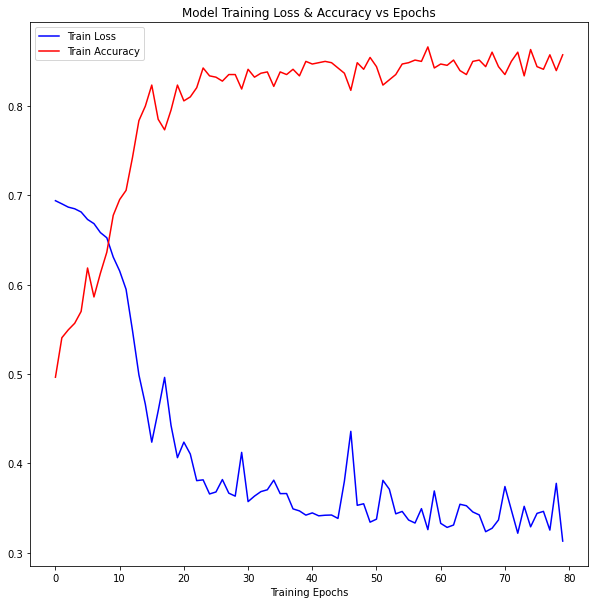

In [15]:
# Plotting Training loss vs Epochs 
def plot_curves(history): 
    
    print('\nMODEL TRAINING RESULTS\n')
    plt.figure(figsize=(10,10))
    plt.plot(history.history['loss'], color = 'blue')
    plt.plot(history.history['accuracy'], color = 'red')
    plt.title('Model Training Loss & Accuracy vs Epochs')
    plt.xlabel('Training Epochs')
    plt.legend(['Train Loss', 'Train Accuracy'], loc='best')
    plt.show()
        
plot_curves(history)

CONFUSION MATRIX: 

            pred:0.0  pred:1.0
  true:0.0        40        23
  true:1.0        13       218

CLASSFICATION REPORT: 

              precision    recall  f1-score   support

         0.0       0.75      0.63      0.69        63
         1.0       0.90      0.94      0.92       231

    accuracy                           0.88       294
   macro avg       0.83      0.79      0.81       294
weighted avg       0.87      0.88      0.87       294


MODEL PREDICTIONS VS ACTUAL: 



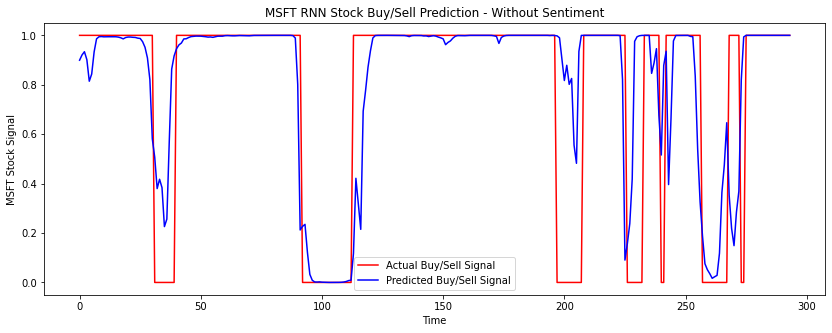

In [16]:
# Testing Initial Model 
# Printing Confusion Matrix, Classification Report, and Visualizing Predicted Signal
tf.keras.utils.plot_model(model, to_file='TSLA-RNN-without-Sentiment-Normal.png', show_shapes=True)
eval_model(model, X_test, y_test)

### Hyperparameter Tuning
- Creating Hyper parameter model and using the RandomSearch tuner class for performing tuning. 
- Tuner obtains the best values for hyperparameters such as input llayer units, input lyaer dropout, hidden layer cells, and learning rate 
- Using the best values, we create another model to find the optimal number 
of epochs which minimizes training loss
- Lastly, create a final model which uses the optimal values for hyperparameters and epochs to build the best model and performing evaluation

In [17]:
def model_builder(hp):

    #Defining Model 
    hyper_model = Sequential()

    hyper_model.add(RNN(SimpleRNNCell(hp.Int('input_layer', 10, 90, step=10), activation = 'relu'), 
                                      input_shape = (X_train.shape[1], X_train.shape[2])))
    hyper_model.add(Dropout(hp.Choice('Drop1', values = [0.1,0.2,0.3])))
        
    hyper_model.add(Dense(units = hp.Choice('hidden_1', values = [10,20,30,60,80,100]), activation = 'relu'))
        
    hyper_model.add(Dense(units = 1, activation = 'sigmoid'))
        
    hyper_model.compile(optimizer = Adam(learning_rate=hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                        loss = BinaryCrossentropy(), metrics=['accuracy'])
        
    return hyper_model


In [18]:
# Defining Random Search Tuner and performing hyperparameter tuning
obj = kt.Objective("loss", direction="min")
tuner = kt.tuners.randomsearch.RandomSearch(model_builder, objective=obj, max_trials=25, seed=42, overwrite = True)

tuner.search(X_train, y_train, epochs=80)

# Get the optimal hyperparameter values for model layers
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 

The optimal number of units in the input layer is {best_hps.get('input_layer')}. 
The optimal amount of dropout in the input layer is {best_hps.get('Drop1')}. 
The optimal number of units in the first hidden layer is {best_hps.get('hidden_1')}. 
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


Trial 25 Complete [00h 00m 10s]
loss: 0.6749030351638794

Best loss So Far: 0.2622322142124176
Total elapsed time: 00h 04m 22s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 

The optimal number of units in the input layer is 60. 
The optimal amount of dropout in the input layer is 0.1. 
The optimal number of units in the first hidden layer is 30. 
The optimal learning rate is 0.001.



#### Evaluating Tuned Model 
- In Step One, we create the model using the best hyperparameter values identified during tuning. Then we find the epoch in which we obtain our objective. 

- In Step Two, we recreate the model using the optimal hyperparameter values and the ideal number of training epochs. Then we train and evaluate this model to compare results against the first non-tuned model with random parameters

In [19]:
#Step One
model_Two = tuner.hypermodel.build(best_hps)
history = model_Two.fit(X_train, y_train, epochs=80)

acc_per_epoch = history.history['accuracy']
best_epoch = acc_per_epoch.index(max(acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/80
22/22 [==============================] - 1s 5ms/step - loss: 0.6950 - accuracy: 0.5054
Epoch 2/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6917 - accuracy: 0.5399
Epoch 3/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6882 - accuracy: 0.5486
Epoch 4/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5774
Epoch 5/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.5602
Epoch 6/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.6119
Epoch 7/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6655 - accuracy: 0.6043
Epoch 8/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6201 - accuracy: 0.6628
Epoch 9/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6162 - accuracy: 0.6760
Epoch 10/80
22/22 [==============================] - 0s 5ms/step - loss: 0.5460 - accuracy: 0.7369
Epoch 11/80
22/22 [

In [20]:
#Step Two
model_three = tuner.hypermodel.build(best_hps)

# Retrain the final model using the best number of epochs
tuned_history = model_three.fit(X_train, y_train, epochs=best_epoch)

Epoch 1/80
22/22 [==============================] - 1s 5ms/step - loss: 0.6920 - accuracy: 0.5028
Epoch 2/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6894 - accuracy: 0.5237
Epoch 3/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5943
Epoch 4/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6796 - accuracy: 0.6069
Epoch 5/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6718 - accuracy: 0.5962
Epoch 6/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6497 - accuracy: 0.6571
Epoch 7/80
22/22 [==============================] - 0s 5ms/step - loss: 0.6249 - accuracy: 0.6647
Epoch 8/80
22/22 [==============================] - 0s 5ms/step - loss: 0.5713 - accuracy: 0.7222
Epoch 9/80
22/22 [==============================] - 0s 5ms/step - loss: 0.5363 - accuracy: 0.7578
Epoch 10/80
22/22 [==============================] - 0s 5ms/step - loss: 0.4768 - accuracy: 0.7871
Epoch 11/80
22/22 [


MODEL TRAINING RESULTS



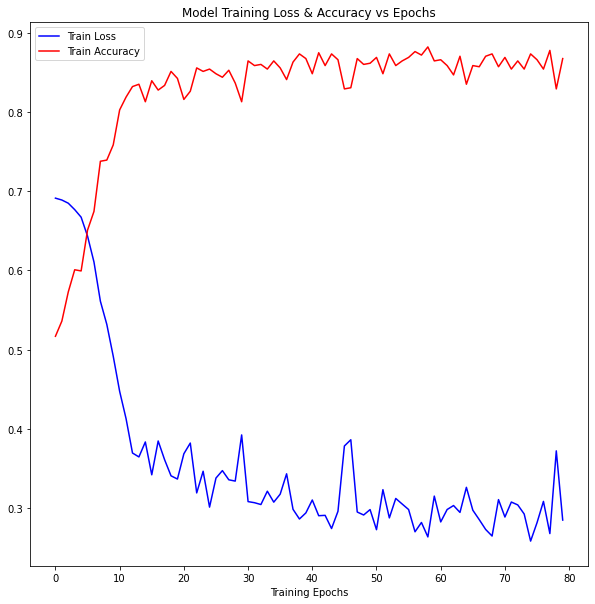

In [21]:
plot_curves(tuned_history)

10/10 [==============================] - 0s 2ms/step - loss: 2.3877 - accuracy: 0.8605
[test loss, test accuracy]: [2.3877265453338623, 0.8605442047119141]
CONFUSION MATRIX: 

            pred:0.0  pred:1.0
  true:0.0        26        37
  true:1.0         4       227

CLASSFICATION REPORT: 

              precision    recall  f1-score   support

         0.0       0.87      0.41      0.56        63
         1.0       0.86      0.98      0.92       231

    accuracy                           0.86       294
   macro avg       0.86      0.70      0.74       294
weighted avg       0.86      0.86      0.84       294


MODEL PREDICTIONS VS ACTUAL: 



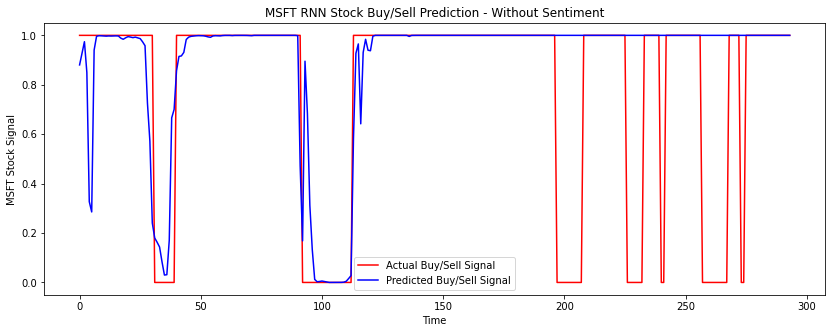

In [22]:
# Tuned Model Evaluation
# Printing Confusion Matrix, Classification Report, and Visualizing the Predicted Signal
eval_result = model_three.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)
tf.keras.utils.plot_model(model_three, to_file='TSLA-RNN-without-Sentiment-Tuned.png', show_shapes=True)
eval_model(model_three, X_test, y_test)